Convolutional Sparse Coding (ADMM)
==================================

This example demonstrates the solution of a simple convolutional sparse
coding problem

  $$\mathrm{argmin}_{\mathbf{x}} \; \frac{1}{2} \Big\| \mathbf{y} -
  \sum_k \mathbf{h}_k \ast \mathbf{x}_k \Big\|_2^2 + \lambda \sum_k
  ( \| \mathbf{x}_k \|_1 - \| \mathbf{x}_k \|_2 ) \;,$$

where the $\mathbf{h}$_k is a set of filters comprising the dictionary,
the $\mathbf{x}$_k is a corrresponding set of coefficient maps, and
$\mathbf{y}$ is the signal to be represented. The problem is solved via
an ADMM algorithm using the frequency-domain approach proposed in
<cite data-cite="wohlberg-2014-efficient"/>.

In [1]:
import numpy as np

import jax

import scico.numpy as snp
from scico import plot
from scico.examples import create_conv_sparse_phantom
from scico.functional import L1MinusL2Norm
from scico.linop import CircularConvolve, Identity, Sum
from scico.loss import SquaredL2Loss
from scico.optimize.admm import ADMM, FBlockCircularConvolveSolver
from scico.util import device_info
plot.config_notebook_plotting()

Set problem size and create random convolutional dictionary (a set of
filters) and a corresponding sparse random set of coefficient maps.

In [2]:
N = 128  # image size
Nnz = 128  # number of non-zeros in coefficient maps
h, x0 = create_conv_sparse_phantom(N, Nnz)

Normalize dictionary filters and scale coefficient maps accordingly.

In [3]:
hnorm = np.sqrt(np.sum(h**2, axis=(1, 2), keepdims=True))
h /= hnorm
x0 *= hnorm

Convert numpy arrays to jax arrays.

In [4]:
h = jax.device_put(h)
x0 = jax.device_put(x0)

Set up sum-of-convolutions forward operator.

In [5]:
C = CircularConvolve(h, input_shape=x0.shape, ndims=2)
S = Sum(input_shape=C.output_shape, axis=0)
A = S @ C

Construct test image from dictionary $\mathbf{h}$ and coefficient maps
$\mathbf{x}_0$.

In [6]:
y = A(x0)

Set functional and solver parameters.

In [7]:
λ = 1e0  # l1-l2 norm regularization parameter
ρ = 2e0  # ADMM penalty parameter
maxiter = 200  # number of ADMM iterations

Define loss function and regularization. Note the use of the
$\ell_1 - \ell_2$ norm, which has been found to provide slightly better
performance than the $\ell_1$ norm in this type of problem
<cite data-cite="wohlberg-2021-psf"/>.

In [8]:
f = SquaredL2Loss(y=y, A=A)
g0 = λ * L1MinusL2Norm()
C0 = Identity(input_shape=x0.shape)

Initialize ADMM solver.

In [9]:
solver = ADMM(
    f=f,
    g_list=[g0],
    C_list=[C0],
    rho_list=[ρ],
    alpha=1.8,
    maxiter=maxiter,
    subproblem_solver=FBlockCircularConvolveSolver(check_solve=True),
    itstat_options={"display": True, "period": 10},
)

Run the solver.

In [10]:
print(f"Solving on {device_info()}\n")
x1 = solver.solve()
hist = solver.itstat_object.history(transpose=True)

Solving on CPU



Iter  Time      Objective  Prml Rsdl  Dual Rsdl  Slv Res  
----------------------------------------------------------
   0  3.16e-01  2.107e+03  3.851e+01  5.291e+01  7.229e-06
  10  5.43e-01  2.862e+03  4.623e+00  9.837e+00  4.373e-06
  20  6.30e-01  2.702e+03  2.097e+00  6.156e+00  5.701e-06


  30  7.05e-01  2.626e+03  1.528e+00  4.603e+00  6.200e-06
  40  7.77e-01  2.578e+03  1.222e+00  3.719e+00  8.564e-06
  50  8.50e-01  2.542e+03  1.124e+00  3.478e+00  7.865e-06


  60  9.25e-01  2.511e+03  1.053e+00  3.260e+00  1.318e-05
  70  1.00e+00  2.486e+03  9.754e-01  3.012e+00  1.255e-05


  80  1.08e+00  2.464e+03  8.965e-01  2.773e+00  5.969e-06
  90  1.16e+00  2.444e+03  8.411e-01  2.613e+00  1.022e-05
 100  1.24e+00  2.426e+03  8.010e-01  2.495e+00  1.429e-05


 110  1.32e+00  2.411e+03  7.589e-01  2.367e+00  8.354e-06
 120  1.40e+00  2.398e+03  7.139e-01  2.224e+00  1.338e-05


 130  1.48e+00  2.386e+03  6.680e-01  2.077e+00  1.682e-05
 140  1.57e+00  2.377e+03  6.111e-01  1.881e+00  1.240e-05
 150  1.65e+00  2.368e+03  5.547e-01  1.717e+00  4.472e-06


 160  1.74e+00  2.361e+03  5.135e-01  1.595e+00  7.214e-06
 170  1.82e+00  2.356e+03  4.665e-01  1.439e+00  9.240e-06


 180  1.90e+00  2.352e+03  4.243e-01  1.301e+00  5.187e-06
 190  1.97e+00  2.348e+03  3.730e-01  1.135e+00  9.683e-06
 199  2.05e+00  2.347e+03  3.064e-01  8.974e-01  6.658e-06


Show the recovered coefficient maps.

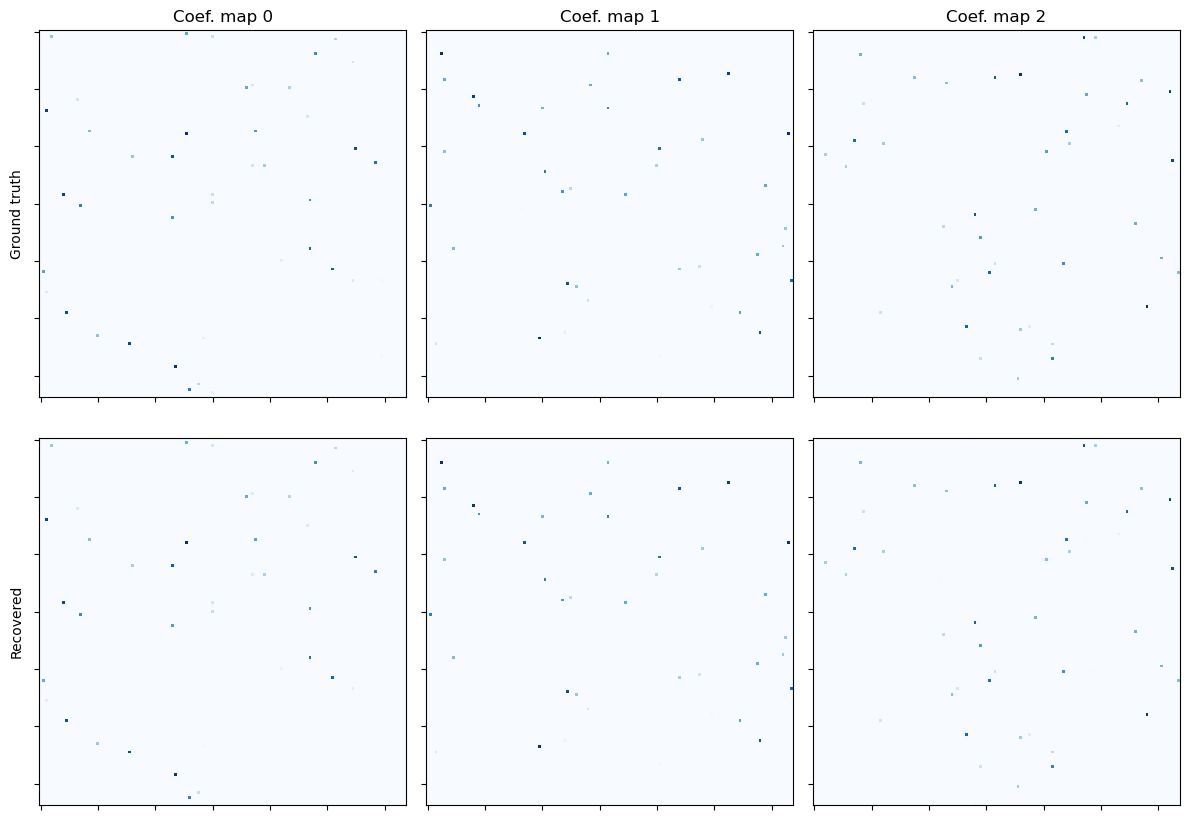

In [11]:
fig, ax = plot.subplots(nrows=2, ncols=3, figsize=(12, 8.6))
plot.imview(x0[0], title="Coef. map 0", cmap=plot.cm.Blues, fig=fig, ax=ax[0, 0])
ax[0, 0].set_ylabel("Ground truth")
plot.imview(x0[1], title="Coef. map 1", cmap=plot.cm.Blues, fig=fig, ax=ax[0, 1])
plot.imview(x0[2], title="Coef. map 2", cmap=plot.cm.Blues, fig=fig, ax=ax[0, 2])
plot.imview(x1[0], cmap=plot.cm.Blues, fig=fig, ax=ax[1, 0])
ax[1, 0].set_ylabel("Recovered")
plot.imview(x1[1], cmap=plot.cm.Blues, fig=fig, ax=ax[1, 1])
plot.imview(x1[2], cmap=plot.cm.Blues, fig=fig, ax=ax[1, 2])
fig.tight_layout()
fig.show()

Show test image and reconstruction from recovered coefficient maps.

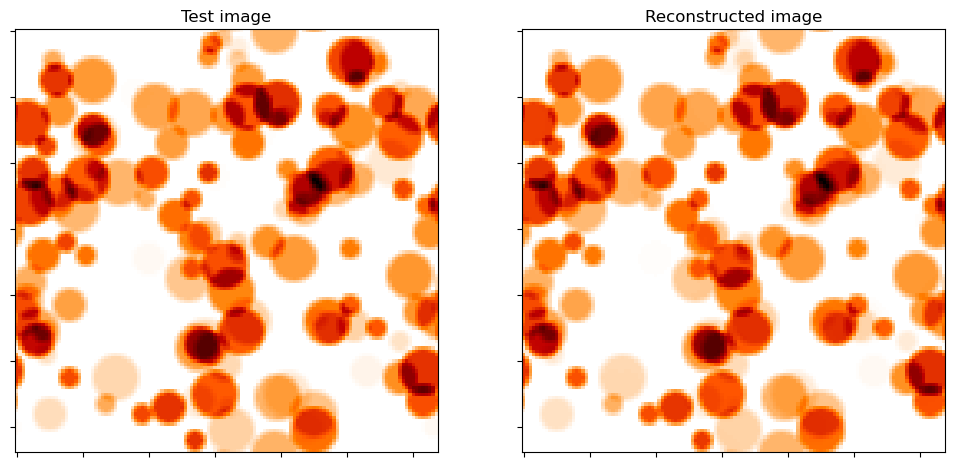

In [12]:
fig, ax = plot.subplots(nrows=1, ncols=2, figsize=(12, 6))
plot.imview(y, title="Test image", cmap=plot.cm.gist_heat_r, fig=fig, ax=ax[0])
plot.imview(A(x1), title="Reconstructed image", cmap=plot.cm.gist_heat_r, fig=fig, ax=ax[1])
fig.show()

Plot convergence statistics.

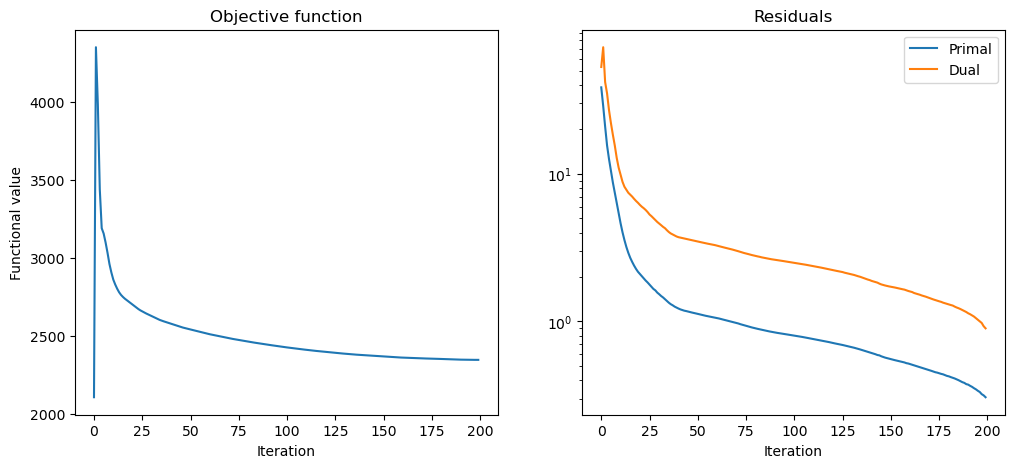

In [13]:
fig, ax = plot.subplots(nrows=1, ncols=2, figsize=(12, 5))
plot.plot(
    hist.Objective,
    title="Objective function",
    xlbl="Iteration",
    ylbl="Functional value",
    fig=fig,
    ax=ax[0],
)
plot.plot(
    snp.vstack((hist.Prml_Rsdl, hist.Dual_Rsdl)).T,
    ptyp="semilogy",
    title="Residuals",
    xlbl="Iteration",
    lgnd=("Primal", "Dual"),
    fig=fig,
    ax=ax[1],
)
fig.show()